# Plot the total forcing (incl ice-abedo) on a map and over time
# for SINGLE cell runs
### Used for:
    - hom_single...
## Should work in the loop

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)

In [2]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)

In [3]:
def get_time(y):
    return (y+54783-1-1810)*360-0.5
def get_year(t):
    return (t+0.5)/360 +1810+1-54783
    #return (t+54783-1-1810)*360-0.5

In [4]:
def area_mean_lon(x, lats=data_grid.yt_j, lon=data_grid.xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)

In [5]:


X,Y = np.meshgrid(np.insert(data_grid.xu_i,0,0), data_grid.yu_j)

x,y=np.meshgrid(data_grid.xt_i, data_grid.yt_j)

def change_to_Atl(x, grid=data_grid):
    new_x=np.copy(x)
    #print(np.shape(new_x))
    switch=np.where(grid.xt_i>180)[0][0]
    for i in range(0,len(grid.xt_i)):
        if grid.xt_i[i]>180:
            new_x[:,i-switch]=x[:,i]
            #print(i-switch)
        else:
            new_x[:,i+switch]=x[:,i]
            #print(i+switch)
    return new_x
#frlnd_atl=change_to_Atl(p[-1].frlnd[0])
X_atl=X-180
Y_atl=Y

In [6]:
def get_P(single, country, fut2250, SSP, opt):
    if single:
        P_folder="../data_preparation/PMIP/P_hum/"
        addendum=country.lower()+"_cell_"
        if country=="AU": P_folder+="txt_file_au_cell_each_yearJul13_13-24"
        elif country=="AM": P_folder+="txt_file_am_cell_each_yearJul13_13-24"
        elif country=="EU": P_folder+="txt_file_eu_cell_each_yearJul13_13-24"
        elif country=="SH": P_folder+="txt_file_sh_cell_each_yearJul13_13-24"
        elif country=="VA": P_folder+="txt_file_va_cell_each_yearJul13_13-24"
        else:
            print("wrong country")
    else:
        P_folder="../data_preparation/PMIP/P_hum/"
        P_folder+="txt_file_each_yearJul13_11-20"
        if SSP: 
            P_folder_fut="../data_preparation/future/"
            if opt=="1WB":
                P_folder_fut+="txt_file_each_yearJul14_16-12opt1"
            else:
                P_folder_fut+="txt_file_each_yearJul14_15-25opt2"
        addendum=""

    P=[]
    maxyear=2101
    if fut2250: maxyear=2251
    P_years=np.arange(1810,maxyear,step=1)
    P2010=np.loadtxt(
                P_folder+"/P_hum_"+addendum+"year2010.dat")
    for y in P_years:
        if y>2010:
            if SSP:
                P.append(np.loadtxt(P_folder_fut+"/P_hum_"+addendum+"year"+str(y)+".dat"))
            else:
                P.append(1.02**(y-2010)*P2010)
        else:
            P.append(np.loadtxt(
                P_folder+"/P_hum_"+addendum+"year"+str(y)+".dat"))
    return P, P_years

def get_S_field():
        # solar insolation (gridpoints x) in W/m^2
        return 1361./4*(1-0.477*0.5*(3*np.sin(y*np.pi/180)**2-1))
#S=get_S_field()
#plt.pcolormesh(X,Y,S)
#plt.colorbar(label="mean W/m^2")

In [7]:
def get_ocean_heat_uptake(years, oc_runname):
    mainfolder=climber_path+"cluster_results/data_Mai8files/"
    oc_reffolder=mainfolder
    oc_refname="hom_REF" 
    oc_folder_ref=oc_reffolder+"c3beta_anthrHeat_"+oc_refname+'/'
    oc_data_ref= xr.open_dataset(oc_folder_ref+"history_short.nc", decode_times=False)

    #oc_runname="hom_P-2Pr_const"
    oc_folder_p=mainfolder+"c3beta_anthrHeat_"+oc_runname+'/'
    oc_data_p= xr.open_dataset(oc_folder_p+"history_short.nc", decode_times=False)
    #print("Region Ocean Heat Uptake in 2100: ", 
    #      oc_data_p.hflx_ave[ind].values*41867.28072 - oc_data_ref.hflx_ave[ind].values*41867.28072 )
    oc_heat_uptake=[]
    for y in years:
        ind=np.where(oc_data_ref.Time == get_time(y))
        oc_heat_uptake.append(
            oc_data_p.hflx_ave[ind].values[0]*41867.28072 - oc_data_ref.hflx_ave[ind].values[0]*41867.28072 )
    return np.array(oc_heat_uptake)

In [9]:
def run(climber_path, refname, runname, country, single=True):
    
    if country=='AU': name='Australia'
    if country=='EU': name='EU'
    if country=='AM': name='US'
    if country=='SH': name='China'
    if country=='VA': name='Vancouver'
        
    ref=[]
    p=[]
    long_years=np.arange(54863, 55074, step=10)
    years=long_years-54983+2010
    for y in long_years:
        ref.append(xr.open_dataset(
            climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+refname+'/snaps/'+
            "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
        p.append(xr.open_dataset(
            climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+runname+'/snaps/'+
            "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
    diff_as=[]
    for n,i in enumerate(years):
        diff_as.append(p[n].data_vars['as'].mean(dim="Time")-ref[n].data_vars['as'].mean(dim="Time"))
    diff_as=np.array(diff_as)
    
    diff_T=[] # surface air temperatures (mean)
    for n,i in enumerate(years):
        diff_T.append(p[n].data_vars['ts'].mean(dim='Time')-ref[n].data_vars['ts'].mean(dim='Time'))
    diff_T=np.array(diff_T)
    
    #flat_diff_as=diff_as[-1].flatten()
    #flat_diff_T=diff_T[-1].flatten()
    
    S=get_S_field()
    
    P, P_years=get_P(single, country, False, False, "")
    
    
    #####  PLOT TOT FORCING MAP  ##### 
    y=2100
    ind=np.where(years==y)[0][0]
    P_ind=np.where(P_years==y)[0][0]
    forcing=[]
    for i in range(0,len(years)):
        forcing.append(data_grid.frlnd[0].values*P[np.where(P_years==years[i])[0][0]]-S*diff_as[i])
    fig=plt.figure(figsize=(16,9))
    ax=fig.add_subplot(111)
    ax.set_title("Total Forcing in "+str(y)+" $\overline{\Delta F}=$"+'%.3f' % area_mean_lon(forcing[ind])+"$W/m^2$"+
                 '\n'+r", where $\overline{P_{hum}\cdot Fr_{land}}=$"+'%.3f' % \
                 area_mean_lon(data_grid.frlnd[0].values* P[P_ind])+"$W/m^2$"+
                 r", $\overline{-\Delta \alpha_S\cdot S}=$"+'%.3f' % area_mean_lon(-S*diff_as[ind])+"$W/m^2$")
    scale=np.max(abs(forcing[ind]))
    plot=ax.pcolormesh(X_atl, Y_atl, change_to_Atl(forcing[ind]), vmin=-scale, vmax=scale, cmap='bwr')
    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-180,urcrnrlon=180,resolution='c')
    m.drawcoastlines()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cb=plt.colorbar(plot, cax=cax, label=r'$\Delta F = P_{hum}\cdot Fr_{land}-\Delta \alpha_S \cdot S(\theta)$ in $W/m^2$')
    #print(area_mean_lon(forcing))
    plt.close()
    
    
    ######### OCEAN HEAT UPTAKE  ################
    oc_heat_uptake = get_ocean_heat_uptake(years, runname)

    
    ###### PLOT TOT FORCING(S) OVER TIME   ##########
    mean_forcing=[]
    mean_P=[]
    mean_da_S=[]
    for f in forcing:
        mean_forcing.append(area_mean_lon(f))
    for y in years:
        mean_P.append(area_mean_lon(P[np.where(P_years==y)[0][0]]*data_grid.frlnd[0].values))
    for a in diff_as:
        mean_da_S.append(area_mean_lon(a*S))
    mean_forcing=np.array(mean_forcing)-oc_heat_uptake
    mean_P=np.array(mean_P)
    mean_da_S=np.array(mean_da_S)

    fig=plt.figure(figsize=(4.5,5))
    ax=fig.add_subplot(111)
    ax.plot(years, mean_forcing, '-', color='black', label=r'$\overline{\Delta F}$',  lw=3)
            #+"\n"+
            #r'$\overline{P_{\rm hum}\cdot  {\rm Fr}_{\rm land}}$'+
            #'\n'+r'$\overline{-\Delta \alpha_S \cdot S}$'+
            #'\n'+r'$\overline{\Delta {\rm OHU}}$', lw=3)
    #ax.plot(years, exp(years, *popt), ':', color='black', label="exp. fit: ")
    ax.plot(years, mean_P, '--', color='red', label=r'$\overline{P_{\rm hum} \cdot {\rm Fr}_{\rm land}}$', lw=3)
    ax.plot(years, -mean_da_S,  '-.', color='c', label=r'$\overline{- \Delta \alpha_S \cdot S}$', lw=3)
    ax.plot(years, -oc_heat_uptake, ':', color='blue', label=r'$\overline{- \Delta {\rm OHU}}$', lw=3)

    ax.grid()
    ax.set_yticklabels(["" for i in ax.get_yticks()])

    ax.axhline(y=0, color='black')
    ax.set_ylabel(r"global forcing $[{\rm W/m^2}]$")
    ax.legend(loc='best', fontsize=16)
    ax.set_xlim(1900, 2100)
    fs=16
    if name=='China':    
        ax.text(2102, (mean_forcing)[-1]+0.01,  '%.3f' % ((mean_forcing)[-1]), fontsize=fs, color='black')
    else:
        ax.text(2102, (mean_forcing)[-1],  '%.3f' % ((mean_forcing)[-1]), fontsize=fs, color='black')
    if name=='Australia':
        ax.text(2102, mean_P[-1]+0.01,  '%.3f' % (mean_P[-1]), fontsize=fs, color='red')
    else:
        ax.text(2102, mean_P[-1],  '%.3f' % (mean_P[-1]), fontsize=fs, color='red')
    ax.text(2102, -mean_da_S[-1],  '%.3f' % (-mean_da_S[-1]), fontsize=fs, color='c')
    ax.text(2102, -oc_heat_uptake[-1],  '%.3f' % (-oc_heat_uptake[-1]), fontsize=fs, color='blue')
    ax.text(2102, 0,  '%.3f'% 0.00, fontsize=fs, color='dimgray')
    ax.text(2102, 0.05,  '%.3f'% 0.05, fontsize=fs, color='dimgray')
    ax.text(2085, 0.28,  r"$[{\rm W/m^2}]$", fontsize=fs)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim(-0.13, 0.27)
    ax.set_ylabel(r"global forcing $[{\rm W/m^2}]$")
    ax.legend(fontsize=16)
    ax.set_title(name+"  ")

    fig.tight_layout()
    plt.savefig("tot_forcing_"+runname+".eps", format='eps', bbox_inches='tight')
    
    return mean_forcing, mean_P, mean_da_S, oc_heat_uptake

In [10]:
#m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')
#m.drawcoastlines()
#plt.pcolormesh(X_atl, Y_atl, change_to_Atl(P[-1]))
#np.max(P[-1])

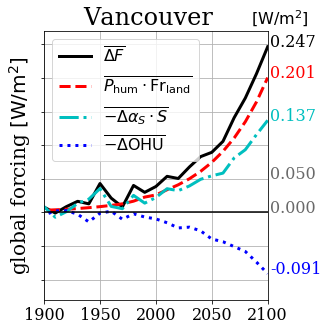

In [11]:

refname="hom_REF"
country="VA"

runname="hom_single"+country+""
single=True
mean_forcing, mean_P, mean_da_S, oc_heat_uptake = run(climber_path, refname, runname, country, single=True)


('AU', ':  tot_forcing_hom_singleAU.eps')
(0.11420557571447779, ' is the ice albedo')
(-0.12716407558022608, ' is the ocean heat Uptake')
('AM', ':  tot_forcing_hom_singleAM.eps')
(0.10720217813151948, ' is the ice albedo')
(-0.082926001970852814, ' is the ocean heat Uptake')
('EU', ':  tot_forcing_hom_singleEU.eps')
(0.11630746742073557, ' is the ice albedo')
(-0.07368833834681715, ' is the ocean heat Uptake')
('SH', ':  tot_forcing_hom_singleSH.eps')
(0.087920612090104905, ' is the ice albedo')
(-0.07570400098186908, ' is the ocean heat Uptake')
('VA', ':  tot_forcing_hom_singleVA.eps')
(0.13703380382704314, ' is the ice albedo')
(-0.091081067986932218, ' is the ocean heat Uptake')


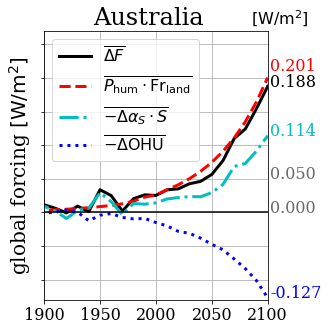

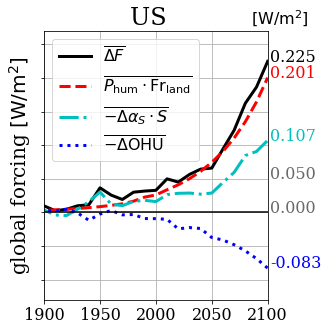

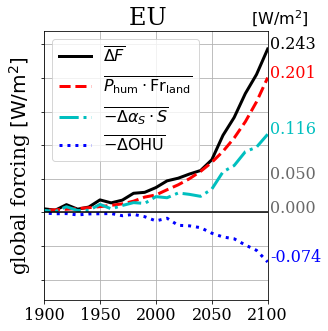

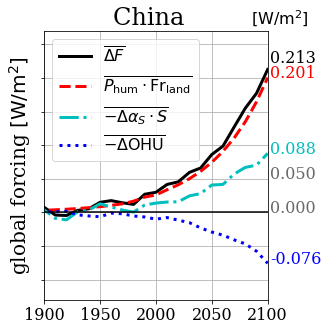

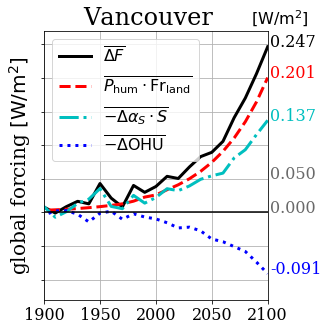

In [12]:
for country in ["AU", "AM", "EU", "SH", "VA"]:
    runname="hom_single"+country+""
    print(country, ":  tot_forcing_"+runname+".eps")
    mean_forcing, mean_P, mean_da_S, oc_heat_uptake = run(climber_path, refname, runname, country, single=True)
    #print((-mean_da_S/mean_forcing)[-1]*100, "% of total forcing ", mean_forcing[-1], " is from ice albedo")
    print(-mean_da_S[-1]," is the ice albedo")
    print(-oc_heat_uptake[-1]," is the ocean heat Uptake")

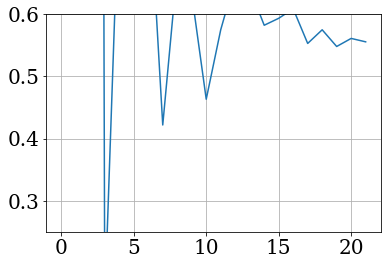

In [13]:
plt.plot(-mean_da_S/mean_forcing)
plt.ylim(0.25,0.6)
plt.grid()